# Neural networks quantization

Today we will deal with neural networks quantization!

Our goal is to reduce network size while keeping the accuracy high! Using smaller number of bits for numbers representation allows for faster inference on edge - embedded devices.

For the purpose of we will Neural networks quantization use Xilinx (now AMD) Brevitas framework and PyTorch. Be aware that there are other frameworks to choose from: build-in PyTorch quantization, Intel's OpenVINO, NVIDIA's TensorRT and others.

Use this link for Brevitas reference and documentation: https://xilinx.github.io/brevitas/index.html.

First, install and import necessary libraries.

In [ ]:
!pip3 install brevitas

In [2]:
import numpy as np
import torch
import brevitas
from torch import nn
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, RandomRotation
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod
from typing import Any
from typing import Tuple
import tqdm
from brevitas import nn as qnn
from brevitas.core.quant import QuantType
from brevitas.quant import (
    Int8ActPerTensorFloat,
    Int8WeightPerTensorFixedPoint,
    Uint8ActPerTensorFloat,
)
from brevitas.quant import Int16Bias
from brevitas import config
from brevitas.graph.calibrate import bias_correction_mode, calibration_mode
import utils as u

In [2]:
config.IGNORE_MISSING_KEYS = True
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)
torch.manual_seed(0)

cpu


Let's start with...

##Post-training quantization (PTQ)

Post-training model optimization is the process of applying transforming the model's parameters and values into a more hardware-friendly representation without retraining or fine-tuning. It is the easiest method of quantization, so let's start there.

The use of quantization carries certain implications. These are most easily observed for more complex problems and larger neural networks. However, working with such cases is time-consuming (long training).

As an alternative approach, we will test quantization for a simple task (MNIST classification) but with additional augmentation (more difficult cases) and for a very small network. In addition, we will focus on quantizing floating-point values to INT4 (rather than the more common INT8 used often in practice). In this way, the effects of quantization should be noticeable.

4-bit integer quantization lowers the precision of weights and activations to 4 bits, which leads to significant reduction in the model footprint and significant improvements in inference speed.

So, first, we need a model to quantize. Reuse metric, loss function, train_test_pass and training functions from prevoius exercises.

Train the model for 3 epochs, save the weights (`CNN_epoch3.pth` file) and then train it again for another 3 epochs and save inproved weights (`CNN_epoch6.pth` file). You should get around ~85% accuracy.

Name the final trained model `fp_model`.

Epoch: 1/3


100%|██████████████████████████████| 157/157 [00:00<00:00, 158.54it/s, accuracy=0.7663, loss=1.6998]


Epoch: 2/3


100%|██████████████████████████████| 157/157 [00:00<00:00, 159.23it/s, accuracy=0.8310, loss=1.6354]


Epoch: 3/3


100%|██████████████████████████████| 157/157 [00:00<00:00, 159.12it/s, accuracy=0.8511, loss=1.6132]


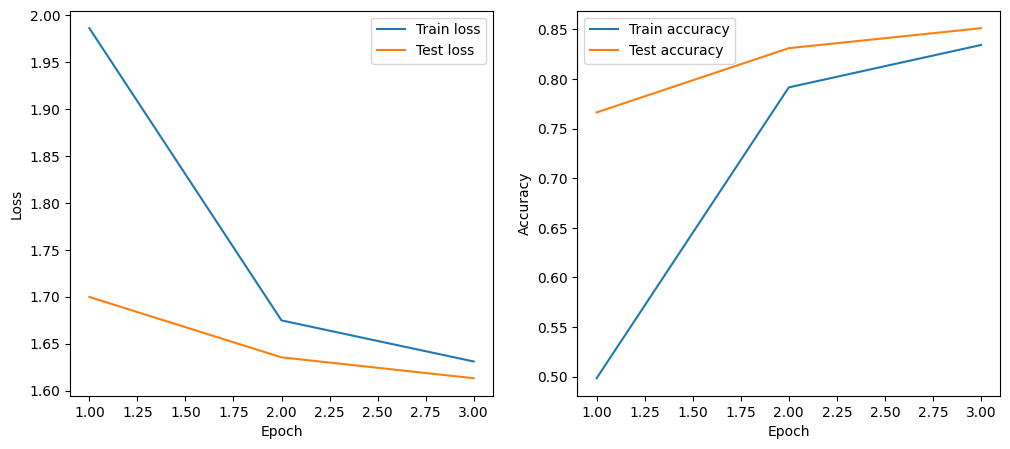

Epoch: 1/3


100%|██████████████████████████████| 157/157 [00:01<00:00, 116.03it/s, accuracy=0.8570, loss=1.6055]


Epoch: 2/3


100%|██████████████████████████████| 157/157 [00:01<00:00, 128.94it/s, accuracy=0.8625, loss=1.6003]


Epoch: 3/3


100%|██████████████████████████████| 157/157 [00:00<00:00, 158.07it/s, accuracy=0.8611, loss=1.6017]


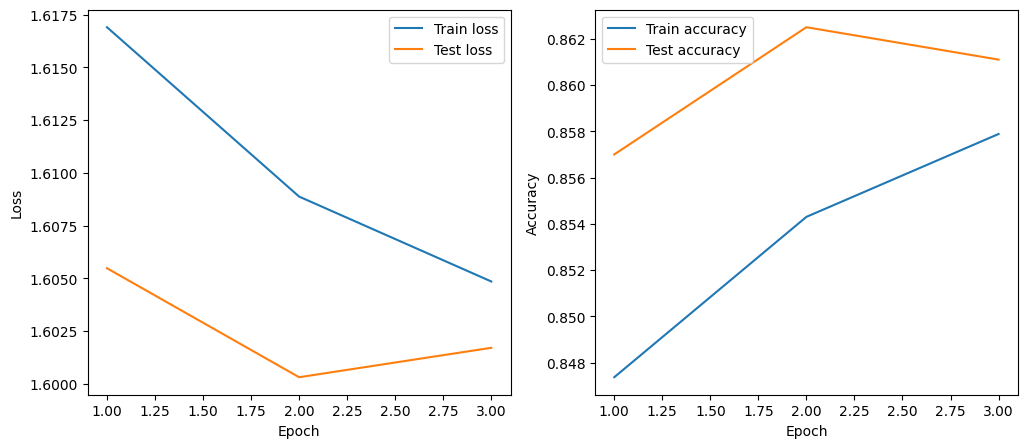

In [8]:
class CNN(nn.Module):
    def __init__(self, input_shape, num_of_cls) -> None:
        super().__init__()
        ch_in = input_shape[0]
        self.conv1 = nn.Conv2d(ch_in,8,3,padding=(1,1))
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2,2)

        self.conv2 = nn.Conv2d(8,16,3,padding=(1,1))
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2,2)

        CNN_out_size = 16*7*7

        self.linear = nn.Linear(CNN_out_size, num_of_cls)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = x.flatten(1)
        x = self.linear(x)
        y = torch.softmax(x,dim=1)
        return y

aug = transforms.Compose([transforms.RandomHorizontalFlip(1), transforms.RandomRotation(45), ToTensor()])

train_dataset = datasets.MNIST('data',
                              train=True,
                              download=True,
                              transform=aug)
test_dataset = datasets.MNIST('data',
                              train=False,
                              download=True,
                              transform=aug)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

input_shape = (1, 28, 28)
output_size = 10

FP_MODEL = CNN(input_shape, output_size)
metric = u.AccuracyMetric()
loss_fcn = nn.CrossEntropyLoss()
fpt_optimizer = torch.optim.SGD(FP_MODEL.parameters(), lr=0.01, momentum=0.9)

FP_MODEL, history = u.test_or_train(
    model=FP_MODEL,
    train_loader=train_loader,
    test_loader=test_loader,
    loss_fn=loss_fcn,
    metric=metric,
    optimizer=fpt_optimizer,
    update_period=1,
    epoch_max=3,
    device=device,
    mode='both',
    early_stopping_accuracy=0.99
)
sd = {'model': FP_MODEL.state_dict(), 'opt': fpt_optimizer.state_dict()}
torch.save(sd, './modelsCNN_epoch3.pth')
u.draw_acc_loss(range(1, len(history["loss_train"]) + 1), history)

FP_MODEL, history = u.test_or_train(
    model=FP_MODEL,
    train_loader=train_loader,
    test_loader=test_loader,
    loss_fn=loss_fcn,
    metric=metric,
    optimizer=fpt_optimizer,
    update_period=1,
    epoch_max=3,
    device=device,
    mode="both",
    early_stopping_accuracy=0.99,
)
sd2 = {'model': FP_MODEL.state_dict(), 'opt': fpt_optimizer.state_dict()}
torch.save(sd2, './models/CNN_epoch6.pth')
u.draw_acc_loss(range(1, len(history["loss_train"]) + 1), history)

Now - we will quantize this model's weights to INT4.

For this purpose we need to create a new `QuantCNN` class and redefine the model. Instead of `nn.Conv2d` layers use `qnn.QuantConv2d` and instead of `nn.Linear` use `qnn.QuantLinear`. Those layers take the same inputs as previous ones, but additionally we need to pass:

*   `weight_bit_width=?` to set the number of bits for weights representation
*   `weight_quant=?` to set the method of quantization. Brevitas exposes various pre-made quantizers. We'll use `Int8WeightPerTensorFixedPoint` to represent weights with FixedPoint (i.e. restricting the scale to a power of two).

Define the class, create the model and load the `./CNN_epoch6.pth` weights.


In [9]:
class QuantCNN(nn.Module):
    def __init__(self, input_shape, num_of_cls) -> None:
        super().__init__()
        ch_in = input_shape[0]
        self.conv1 = qnn.QuantConv2d(ch_in, 8, 3, padding=(1, 1), weight_bit_width=4, weight_quant=Int8WeightPerTensorFixedPoint)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = qnn.QuantConv2d(8, 16, 3, padding=(1, 1), weight_bit_width=4, weight_quant=Int8WeightPerTensorFixedPoint)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)

        CNN_out_size = 16 * 7 * 7

        self.linear = qnn.QuantLinear(CNN_out_size, num_of_cls, weight_bit_width=4, weight_quant=Int8WeightPerTensorFixedPoint)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = x.flatten(start_dim=1)
        x = self.linear(x)
        y = torch.softmax(x, dim=1)
        return y


PTQ_MODEL = QuantCNN(input_shape, output_size)
ptq_optimizer = torch.optim.SGD(PTQ_MODEL.parameters(), lr=0.01, momentum=0.9)
load_epoch6_file = torch.load('./models/CNN_epoch6.pth')
PTQ_MODEL.load_state_dict(load_epoch6_file['model'])

/var/folders/0b/brzkvl1j0tn9xzynh5pr39sw0000gn/T/ipykernel_32607/1762771231.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  load_epoch6_file = torch.load('./models/CNN_

<All keys matched successfully>

After loading the weights we can inspect the original weight tensor and the quantized version to see the effect:

In [10]:
print(f"Original float weight tensor:\n {PTQ_MODEL.conv1.weight} \n")
print(f"Quantized weight QuantTensor:\n {PTQ_MODEL.conv1.quant_weight()} \n")

Original float weight tensor:
 Parameter containing:
tensor([[[[ 0.4694, -0.1149, -0.0505],
          [ 0.6571,  0.7300, -0.2343],
          [ 0.8792,  0.3399,  0.1757]]],


        [[[-0.3757, -0.4125, -0.2420],
          [-0.0146,  0.0853,  0.4025],
          [ 0.1128,  0.4281, -0.1113]]],


        [[[ 0.2162, -0.2823, -0.3159],
          [ 0.2071, -0.2187, -0.1843],
          [-0.2008, -0.1012,  0.1577]]],


        [[[ 0.1657, -0.2511,  0.0253],
          [-0.2758, -0.2835, -0.0860],
          [-0.0368,  0.1594,  0.1375]]],


        [[[ 0.6536,  1.2271,  0.9091],
          [ 1.0923,  1.8218,  1.2999],
          [ 1.2320,  0.7119,  0.8638]]],


        [[[ 0.6838,  0.8106,  0.2704],
          [ 0.1027,  0.3860,  0.0941],
          [ 0.6053, -0.1112, -0.3647]]],


        [[[-0.0191, -0.3814, -0.4264],
          [ 0.3306,  0.1410,  0.0073],
          [ 0.1179,  0.3711, -0.0249]]],


        [[[ 0.0457,  0.1257,  0.2942],
          [-0.3601, -0.3831, -0.1625],
          [-0.2824, -0

Verify the quantized weights. Calculate a maximum, minimum and average difference between the float and int4 weights.

In [11]:
quantized_weights = PTQ_MODEL.conv1.quant_weight()
difference = PTQ_MODEL.conv1.weight - quantized_weights
max_diff = difference.abs().max()
min_diff = difference.abs().min()
avg_diff = difference.abs().mean()
print(f"Maximum difference: {max_diff}")
print(f"Minimum difference: {min_diff.item()}")
print(f"Average difference: {avg_diff.item()}")

Maximum difference: 0.12434068322181702
Minimum difference: 0.0010585486888885498
Average difference: 0.07095703482627869


/var/folders/0b/brzkvl1j0tn9xzynh5pr39sw0000gn/T/ipykernel_32607/314292157.py:2: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/python_arg_parser.cpp:315.)
  difference = PTQ_MODEL.conv1.weight - quantized_weights


Before we evaluate the quantized model we need to calibrate it. The idea of calibration-based quantization is to perform forward passes only with a small set of data and collect statistics to determine scale factors and zero-points. In this way we can acheve much better accuracy.

Calibrate the model and then evaluate it

In [12]:
def calibrate_model(calibration_loader, quant_model):
    with torch.no_grad():
        # Put the model in calibration mode to collect statistics
        # Quantization is automatically disabled during the calibration, and re-enabled at the end
        with calibration_mode(quant_model):
            for i, (images, _) in enumerate(calibration_loader):
                if i > 5:
                    break
                quant_model(images)

        # Apply bias correction
        with bias_correction_mode(quant_model):
            for i, (images, _) in enumerate(calibration_loader):
                if i > 5:
                    break
                quant_model(images)
    return quant_model

PTQ_MODEL = calibrate_model(test_loader, PTQ_MODEL)

PTQ_MODEL, history = u.test_or_train(
    model=PTQ_MODEL,
    train_loader=train_loader,
    test_loader=test_loader,
    loss_fn=loss_fcn,
    metric=metric,
    optimizer=ptq_optimizer,
    update_period=1,
    epoch_max=1,
    device=device,
    mode="test",
    early_stopping_accuracy=0.99,
)
print(f'PTQ: loss={history['loss_test'][0]} acc={history['acc_test'][0]}')

/Users/szymon/.local/share/virtualenvs/lab4-mAt3T2Ik/lib/python3.12/site-packages/torch/_tensor.py:1488: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/c10/core/TensorImpl.h:1931.)
  return super().rename(names)


Epoch: 1/1


100%|██████████████████████████████| 157/157 [00:01<00:00, 131.18it/s, accuracy=0.8478, loss=1.6150]

PTQ: loss=1.6149570371627808 acc=0.8478


Compare the resulted accuracy with the accuracy of floating point model.

Try to answer the following questions: How much memory did we save with reducing the precision to just 4 bits?

Now, let's focus on another (much better) approach to quantisation:
## Quantization-aware Training (QAT)

Training-time model compression improves model performance by applying optimizations (such as quantization) during the training. The training process minimizes the loss associated with the lower-precision optimizations, so it is able to maintain the model’s accuracy while reducing its latency and memory footprint. Generally, training-time model optimization results in better model performance and accuracy than post-training optimization.

Quantization-aware Training is a popular method that allows quantizing a model and applying fine-tuning to restore accuracy degradation caused by quantization. In fact, this is the most accurate quantization method.

Create another model `qat_model` as on object of `QuantCNN` class. This time however load `./CNN_epoch3.pth` weights. In this way we initialise the model with pre-trained weights.

Then, use your `training()` function to train it for 3 more epochs (you just pass the quantised model, you don't have to change anything else).

That's it! You just did a Quantization-aware Treining. Evaluate the model and compare it's result with PTQ and fully-precision models.

Note that we ran as many iterations of training for QAT as we did for PTQ. However, the second half of the training for QAT was conducted with quantization included. The most common practice is to run first part of the learning for floating-point model and then to fine-tune the model after quantization.

In [13]:
QAT_MODEL = QuantCNN(input_shape, output_size)
qat_optimizer = torch.optim.SGD(QAT_MODEL.parameters(), lr=0.01, momentum=0.9)
load_epoch3_file = torch.load("./models/CNN_epoch3.pth")
QAT_MODEL.load_state_dict(load_epoch3_file["model"])

QAT_MODEL, history = u.test_or_train(
    model=QAT_MODEL,
    train_loader=train_loader,
    test_loader=test_loader,
    loss_fn=loss_fcn,
    metric=metric,
    optimizer=qat_optimizer,
    update_period=1,
    epoch_max=3,
    device=device,
    mode="train",
    early_stopping_accuracy=0.99,
)

QAT_MODEL, history = u.test_or_train(
    model=QAT_MODEL,
    train_loader=train_loader,
    test_loader=test_loader,
    loss_fn=loss_fcn,
    metric=metric,
    optimizer=qat_optimizer,
    update_period=1,
    epoch_max=1,
    device=device,
    mode="test",
    early_stopping_accuracy=0.99,
)
print(f"QAT: loss={history['loss_test'][0]} acc={history['acc_test'][0]}")

/var/folders/0b/brzkvl1j0tn9xzynh5pr39sw0000gn/T/ipykernel_32607/249095032.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  load_epoch3_file = torch.load("./models/CNN_ep

Epoch: 1/3


100%|███████████████████████████████| 938/938 [00:14<00:00, 66.75it/s, accuracy=0.8369, loss=1.6272]


Epoch: 2/3


100%|███████████████████████████████| 938/938 [00:15<00:00, 61.81it/s, accuracy=0.8451, loss=1.6178]


Epoch: 3/3


100%|███████████████████████████████| 938/938 [00:15<00:00, 59.45it/s, accuracy=0.8529, loss=1.6104]


Epoch: 1/1


100%|██████████████████████████████| 157/157 [00:01<00:00, 129.27it/s, accuracy=0.8610, loss=1.6017]

QAT: loss=1.601693789100647 acc=0.861


## Quantisation of activations and bias values

So far we only quantised weights. For embedded applications and real-time processing it is very often necessary to quantise also activation maps and bias values - we need to store all of those in hardware, right?

For feature maps quantization we can use `qnn.QuantIdentity` (among other things). This function takes `bit_width=?` as input, but also `act_quant` (to set the method of quantization). This time we'll use `Int8ActPerTensorFloat` where values are quantized to signed integer with a per-tensor floating-point scale factor.
In order to output quanized values along with quantization parameters we need to set `return_quant_tensor=True` parameter.

Let's try it: Create a Torch Tensor with 10 random values between -1 and 1. Define a qnn.QuantIdentity layer (2 bits) and pass the Tensor through it. Then, print both input and output tensors. Analize it, find the floating-point scale. Calculate difference between tensor values

In [6]:
# Let's try it: Create a Torch Tensor with 10 random values between -1 and 1. Define a qnn.QuantIdentity layer (2 bits) and pass the Tensor through it. Then, print both input and output tensors. Analize it, find the floating-point scale. Calculate difference between tensor values
tensor = torch.randn(10).uniform_(-1, 1)
layer = qnn.QuantIdentity(bit_width=2, act_quant=Int8ActPerTensorFloat, return_quant_tensor=True)
output = layer(tensor)
print(f"Input tensor: {tensor} \n")
print(f"Output tensor: {output} \n")
# Calculate difference between tensor values
difference = tensor - output.tensor
max_diff = difference.abs().max()
min_diff = difference.abs().min()
avg_diff = difference.abs().mean()
print(f"Maximum difference: {max_diff}")
print(f"Minimum difference: {min_diff.item()}")
print(f"Average difference: {avg_diff.item()}")

Input tensor: tensor([ 0.5098, -0.2332, -0.0229, -0.2561, -0.1501,  0.1914,  0.4898,  0.0815,
         0.2371, -0.8951]) 

Output tensor: IntQuantTensor(value=tensor([ 0.4476, -0.4476, -0.0000, -0.4476, -0.0000,  0.0000,  0.4476,  0.0000,
         0.4476, -0.8951], grad_fn=<MulBackward0>), scale=0.4475664496421814, zero_point=0.0, bit_width=2.0, signed_t=True, training_t=True) 

Maximum difference: 0.21433097124099731
Minimum difference: 0.0
Average difference: 0.11666636168956757


We'are ready for model with quantized weight's, activations and biases! For this purpose define yet another class `QuantCNN_extended` with:


*   `qnn.QuantIdentity` before the first Convolution (4 bits)
*   `qnn.QuantReLU` instead of ReLU. We don't need to quantize the outputs of convolutional layers, since we have ReLU activations just after each such layer (we could do that tho). We need to pass `bit_width=4`, `return_quant_tensor=True`, and `act_quant=?`. For ReLU we use `Uint8ActPerTensorFloat` (try to figure out - WHY?).
* for each convolutional and linear layer add `bias_quant=Int16Bias` parameter (we'll use 16 bits for bias. It is not uncommon to use even 32 bits).

Create an object of `QuantCNN_extended`, load `./CNN_epoch3.pth` weights, and train it for 3 epochs. Evaluate the model and compare it's result with PTQ, weights-only QAT and fully-precision models!



In [15]:
class QuantCNN_extended(nn.Module):
    def __init__(self, input_shape, num_of_cls) -> None:
        super().__init__()
        ch_in = input_shape[0]
        self.identity = qnn.QuantIdentity(bit_width=4, act_quant=Int8ActPerTensorFloat, return_quant_tensor=True)
        self.conv1 = qnn.QuantConv2d(ch_in, 8, 3, padding=(1, 1), weight_bit_width=4, weight_quant=Int8WeightPerTensorFixedPoint, bias_quant=Int16Bias)
        self.relu1 = qnn.QuantReLU(bit_width=4, return_quant_tensor=True, act_quant=Uint8ActPerTensorFloat)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = qnn.QuantConv2d(8, 16, 3, padding=(1, 1), weight_bit_width=4, weight_quant=Int8WeightPerTensorFixedPoint, bias_quant=Int16Bias)
        self.relu2 = qnn.QuantReLU(bit_width=4, return_quant_tensor=True, act_quant=Uint8ActPerTensorFloat)
        self.pool2 = nn.MaxPool2d(2, 2)

        CNN_out_size = 16 * 7 * 7

        self.linear = qnn.QuantLinear(CNN_out_size, num_of_cls, weight_bit_width=4, weight_quant=Int8WeightPerTensorFixedPoint, bias_quant=Int16Bias)

    def forward(self, x):
        x = self.identity(x)
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = x.flatten(start_dim=1)
        x = self.linear(x)
        y = torch.softmax(x, dim=1)
        return y

QAT_EXTENDED_MODEL = QuantCNN_extended(input_shape, output_size)
qat_extended_optimizer = torch.optim.SGD(QAT_EXTENDED_MODEL.parameters(), lr=0.01, momentum=0.9)
load_epoch3_file = torch.load("./models/CNN_epoch3.pth")
QAT_EXTENDED_MODEL.load_state_dict(load_epoch3_file["model"])
#train
QAT_EXTENDED_MODEL, history = u.test_or_train(
    model=QAT_EXTENDED_MODEL,
    train_loader=train_loader,
    test_loader=test_loader,
    loss_fn=loss_fcn,
    metric=metric,
    optimizer=qat_extended_optimizer,
    update_period=1,
    epoch_max=3,
    device=device,
    mode="train",
    early_stopping_accuracy=0.99,
)
#evaluate
QAT_EXTENDED_MODEL, history = u.test_or_train(
    model=QAT_EXTENDED_MODEL,
    train_loader=train_loader,
    test_loader=test_loader,
    loss_fn=loss_fcn,
    metric=metric,
    optimizer=qat_extended_optimizer,
    update_period=1,
    epoch_max=1,
    device=device,
    mode="test",
    early_stopping_accuracy=0.99,
)
print(f'QAT - extended: loss={history['loss_test'][0]} acc={history['acc_test'][0]}')

/var/folders/0b/brzkvl1j0tn9xzynh5pr39sw0000gn/T/ipykernel_32607/4178805057.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  load_epoch3_file = torch.load("./models/CNN_

Epoch: 1/3


100%|███████████████████████████████| 938/938 [00:24<00:00, 38.36it/s, accuracy=0.8359, loss=1.6291]


Epoch: 2/3


100%|███████████████████████████████| 938/938 [00:24<00:00, 38.64it/s, accuracy=0.8439, loss=1.6197]


Epoch: 3/3


100%|███████████████████████████████| 938/938 [00:24<00:00, 38.61it/s, accuracy=0.8504, loss=1.6128]


Epoch: 1/1


100%|███████████████████████████████| 157/157 [00:02<00:00, 75.89it/s, accuracy=0.8590, loss=1.6044]

QAT - extended: loss=1.6043708259582519 acc=0.859


Perfect! We got familiar with QAT and PTQ. Now - Let's do some **science**!

We'll focus on QAT. Try to determine what **are the optimal quantization parameters for our model and MNIST classification**. Create a function that creates, inicializes with `./CNN_epoch3.pth` weights, trains and evaluates the network for the following parameters:

* 2 bits for activations, 8 bits for weights
* 2 bits for activations, 4 bits for weights
* 2 bits for activations, 2 bits for weights
* 4 bits for activations, 8 bits for weights
* 4 bits for activations, 4 bits for weights
* 4 bits for activations, 2 bits for weights
* 8 bits for activations, 8 bits for weights
* 8 bits for activations, 4 bits for weights
* 8 bits for activations, 2 bits for weights

For each model, determine **how much memory is needed to store the weights and activations after each layer** (you don't need to store activations between convolution and ReLU). The number of parameters in the model can be determined by the following function, and the number of values in the activations can be determined by analyzing the network model. Ignore the bias.

When the function is finished, it should display a graph of the dependence of the required memory on the accuracy of the model. Based on your analysis of the graph, answer the question, "What is the best option?"



In [32]:
def create_and_train_model(
    input_shape, output_size, act_bit_width, weight_bit_width, calculate_memory_fn
):
    model = QuantCNN_extended(input_shape, output_size)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    load_epoch3_file = torch.load("./models/CNN_epoch3.pth")
    model.load_state_dict(load_epoch3_file["model"])

    for layer in model.children():
        if isinstance(layer, qnn.QuantConv2d) or isinstance(
            layer, qnn.QuantLinear
        ):
            layer.weight_bit_width = weight_bit_width
            layer.act_bit_width = act_bit_width

    model, history = u.test_or_train(
        model=model,
        train_loader=train_loader,
        test_loader=test_loader,
        loss_fn=loss_fcn,
        metric=metric,
        optimizer=optimizer,
        update_period=1,
        epoch_max=3,
        device=device,
        mode="train",
        early_stopping_accuracy=0.99,
    )

    model, history = u.test_or_train(
        model=model,
        train_loader=train_loader,
        test_loader=test_loader,
        loss_fn=loss_fcn,
        metric=metric,
        optimizer=optimizer,
        update_period=1,
        epoch_max=1,
        device=device,
        mode="test",
        early_stopping_accuracy=0.99,
    )

    memory = calculate_memory_fn(model, weight_bit_width, act_bit_width)

    print(
        f"Configuration: Act: {act_bit_width}, Weight: {weight_bit_width}, Loss: {history['loss_test'][0]}, Acc: {history['acc_test'][0]}, Memory: {memory} KB"
    )

    return model, memory, history

In [31]:
def calculate_memory1(model, bits_weights, bits_activations):
    weight_memory = 0
    activation_memory = 0

    # Calculate weights memory
    for name, layer in model.named_modules():
        if isinstance(layer, (qnn.QuantConv2d, qnn.QuantLinear)):
            num_params = layer.weight.numel()
            weight_memory += (
                num_params * bits_weights / 8
            )  # Convert bits to bytes

    # Calculate activations memory
    dummy_input = torch.randn(1, 1, 28, 28)
    model.eval()
    with torch.no_grad():
        device = next(model.parameters()).device
        dummy_input = dummy_input.to(device)
        activations = model(dummy_input)

    for activation in activations:
        activation_memory += (
            activation.numel() * bits_activations / 8
        )  # Convert bits to bytes

    total_memory = weight_memory + activation_memory
    return total_memory / 1024  # Convert to KB

/var/folders/0b/brzkvl1j0tn9xzynh5pr39sw0000gn/T/ipykernel_32607/555700198.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  load_epoch3_file = torch.load("./models/CNN_ep

Epoch: 1/3


100%|███████████████████████████████| 938/938 [00:28<00:00, 33.47it/s, accuracy=0.8358, loss=1.6291]


Epoch: 2/3


100%|███████████████████████████████| 938/938 [00:26<00:00, 35.93it/s, accuracy=0.8437, loss=1.6198]


Epoch: 3/3


100%|███████████████████████████████| 938/938 [00:26<00:00, 35.34it/s, accuracy=0.8499, loss=1.6132]


Epoch: 1/1


100%|███████████████████████████████| 157/157 [00:02<00:00, 65.41it/s, accuracy=0.8607, loss=1.6025]


Configuration: Act: 2, Weight: 2, Loss: 1.6024660491943359, Acc: 0.8607, Memory: 2.21533203125 KB
Epoch: 1/3


100%|███████████████████████████████| 938/938 [00:26<00:00, 35.08it/s, accuracy=0.8375, loss=1.6274]


Epoch: 2/3


100%|███████████████████████████████| 938/938 [00:25<00:00, 36.76it/s, accuracy=0.8457, loss=1.6178]


Epoch: 3/3


100%|███████████████████████████████| 938/938 [00:25<00:00, 36.35it/s, accuracy=0.8486, loss=1.6143]


Epoch: 1/1


100%|███████████████████████████████| 157/157 [00:02<00:00, 73.80it/s, accuracy=0.8579, loss=1.6051]


Configuration: Act: 2, Weight: 4, Loss: 1.605082815361023, Acc: 0.8579, Memory: 4.42822265625 KB
Epoch: 1/3


100%|███████████████████████████████| 938/938 [00:25<00:00, 36.24it/s, accuracy=0.8360, loss=1.6285]


Epoch: 2/3


100%|███████████████████████████████| 938/938 [00:24<00:00, 37.67it/s, accuracy=0.8435, loss=1.6195]


Epoch: 3/3


100%|███████████████████████████████| 938/938 [00:24<00:00, 37.55it/s, accuracy=0.8496, loss=1.6135]


Epoch: 1/1


100%|███████████████████████████████| 157/157 [00:02<00:00, 67.24it/s, accuracy=0.8599, loss=1.6032]


Configuration: Act: 2, Weight: 8, Loss: 1.6031655752182006, Acc: 0.8599, Memory: 8.85400390625 KB
Epoch: 1/3


100%|███████████████████████████████| 938/938 [00:26<00:00, 35.20it/s, accuracy=0.8346, loss=1.6292]


Epoch: 2/3


100%|███████████████████████████████| 938/938 [00:22<00:00, 41.82it/s, accuracy=0.8447, loss=1.6197]


Epoch: 3/3


100%|███████████████████████████████| 938/938 [00:23<00:00, 39.74it/s, accuracy=0.8508, loss=1.6121]


Epoch: 1/1


100%|███████████████████████████████| 157/157 [00:01<00:00, 87.04it/s, accuracy=0.8575, loss=1.6063]


Configuration: Act: 4, Weight: 2, Loss: 1.6062712726593018, Acc: 0.8575, Memory: 2.2177734375 KB
Epoch: 1/3


100%|███████████████████████████████| 938/938 [00:24<00:00, 37.74it/s, accuracy=0.8366, loss=1.6280]


Epoch: 2/3


100%|███████████████████████████████| 938/938 [00:24<00:00, 38.96it/s, accuracy=0.8426, loss=1.6200]


Epoch: 3/3


100%|███████████████████████████████| 938/938 [00:23<00:00, 39.84it/s, accuracy=0.8488, loss=1.6141]


Epoch: 1/1


100%|███████████████████████████████| 157/157 [00:01<00:00, 82.83it/s, accuracy=0.8368, loss=1.6256]


Configuration: Act: 4, Weight: 4, Loss: 1.6255683582305909, Acc: 0.8368, Memory: 4.4306640625 KB
Epoch: 1/3


100%|███████████████████████████████| 938/938 [00:23<00:00, 39.50it/s, accuracy=0.8357, loss=1.6288]


Epoch: 2/3


100%|███████████████████████████████| 938/938 [00:23<00:00, 39.71it/s, accuracy=0.8440, loss=1.6196]


Epoch: 3/3


100%|███████████████████████████████| 938/938 [00:24<00:00, 38.33it/s, accuracy=0.8490, loss=1.6139]


Epoch: 1/1


100%|███████████████████████████████| 157/157 [00:01<00:00, 89.20it/s, accuracy=0.8564, loss=1.6072]


Configuration: Act: 4, Weight: 8, Loss: 1.607184669303894, Acc: 0.8564, Memory: 8.8564453125 KB
Epoch: 1/3


100%|███████████████████████████████| 938/938 [00:23<00:00, 39.63it/s, accuracy=0.8358, loss=1.6290]


Epoch: 2/3


100%|███████████████████████████████| 938/938 [00:22<00:00, 42.48it/s, accuracy=0.8439, loss=1.6196]


Epoch: 3/3


100%|███████████████████████████████| 938/938 [00:22<00:00, 41.07it/s, accuracy=0.8487, loss=1.6141]


Epoch: 1/1


100%|███████████████████████████████| 157/157 [00:01<00:00, 88.82it/s, accuracy=0.8597, loss=1.6038]


Configuration: Act: 8, Weight: 2, Loss: 1.603847659111023, Acc: 0.8597, Memory: 2.22265625 KB
Epoch: 1/3


100%|███████████████████████████████| 938/938 [00:24<00:00, 38.04it/s, accuracy=0.8355, loss=1.6289]


Epoch: 2/3


100%|███████████████████████████████| 938/938 [00:22<00:00, 42.41it/s, accuracy=0.8460, loss=1.6178]


Epoch: 3/3


100%|███████████████████████████████| 938/938 [00:22<00:00, 42.42it/s, accuracy=0.8510, loss=1.6123]


Epoch: 1/1


100%|███████████████████████████████| 157/157 [00:01<00:00, 87.64it/s, accuracy=0.8589, loss=1.6044]


Configuration: Act: 8, Weight: 4, Loss: 1.604436171913147, Acc: 0.8589, Memory: 4.435546875 KB
Epoch: 1/3


100%|███████████████████████████████| 938/938 [00:24<00:00, 37.55it/s, accuracy=0.8351, loss=1.6293]


Epoch: 2/3


100%|███████████████████████████████| 938/938 [00:22<00:00, 41.22it/s, accuracy=0.8457, loss=1.6178]


Epoch: 3/3


100%|███████████████████████████████| 938/938 [00:21<00:00, 42.89it/s, accuracy=0.8515, loss=1.6117]


Epoch: 1/1


100%|███████████████████████████████| 157/157 [00:01<00:00, 90.73it/s, accuracy=0.8585, loss=1.6033]


Configuration: Act: 8, Weight: 8, Loss: 1.6033476655960084, Acc: 0.8585, Memory: 8.861328125 KB


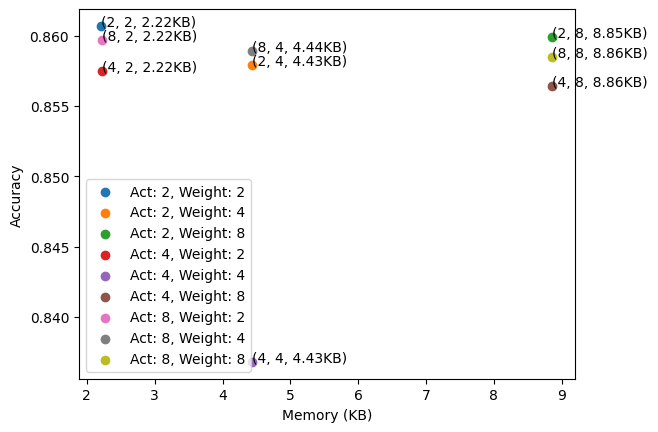

In [33]:
act_bit_widths = [2, 4, 8]
weight_bit_widths = [2, 4, 8]
results = []

for act_bit_width in act_bit_widths:
    for weight_bit_width in weight_bit_widths:
        model, memory, history = create_and_train_model(
            input_shape, output_size, act_bit_width, weight_bit_width, calculate_memory_fn=calculate_memory1
        )
        results.append((act_bit_width, weight_bit_width, memory, history))

fig, ax = plt.subplots()
for result in results:
    ax.scatter(
        result[2],
        result[3]["acc_test"][0],
        label=f"Act: {result[0]}, Weight: {result[1]}",
    )
    ax.text(
        result[2],
        result[3]["acc_test"][0],
        f"({result[0]}, {result[1]}, {result[2]:.2f}KB)",
    )
ax.set_xlabel("Memory (KB)")
ax.set_ylabel("Accuracy")
ax.legend()
plt.show()

In [34]:
def calculate_memory2(
    model, bits_weights, bits_activations, input_size=(1, 28, 28), batch_size=1
):
    weight_memory = 0
    activation_memory = 0

    # Obliczanie pamięci wag (w tym biasów)
    for name, layer in model.named_modules():
        if isinstance(layer, (qnn.QuantConv2d, qnn.QuantLinear)):
            params = list(layer.parameters())
            for param in params:
                num_params = param.numel()
                weight_memory += num_params * bits_weights / 8  # bity na bajty

    # Przygotowanie do zbierania aktywacji
    activations = []

    def hook_fn(module, input, output):
        # Sprawdzamy, czy output jest IntQuantTensor
        if hasattr(output, "value"):
            activations.append(output.value)
        else:
            activations.append(output)

    hooks = []
    for name, layer in model.named_modules():
        if isinstance(layer, (qnn.QuantConv2d, qnn.QuantLinear, qnn.QuantReLU, qnn.MaxPool2d)):
            hooks.append(layer.register_forward_hook(hook_fn))

    # Tworzenie sztucznego wejścia o określonym rozmiarze wsadu i wejścia
    dummy_input = torch.randn(batch_size, *input_size)
    model.eval()
    with torch.no_grad():
        device = next(model.parameters()).device
        dummy_input = dummy_input.to(device)
        model(dummy_input)

    # Usuwanie haków
    for hook in hooks:
        hook.remove()

    # Obliczanie pamięci aktywacji
    for activation in activations:
        if hasattr(activation, "numel"):
            num_elements = activation.numel()
        else:
            # Obliczamy liczbę elementów z kształtu
            num_elements = 1
            for dim in activation.shape:
                num_elements *= dim
        activation_memory += (
            num_elements * bits_activations / 8
        )  # bity na bajty

    total_memory = weight_memory + activation_memory
    return total_memory / 1024  # Bajty na KiB

/var/folders/0b/brzkvl1j0tn9xzynh5pr39sw0000gn/T/ipykernel_32607/3908801053.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  load_epoch3_file = torch.load("./models/CNN_e

Trenowanie modelu z szerokością bitową aktywacji: 2, wag: 2
Epoch: 1/3


100%|███████████████████████████████| 938/938 [00:26<00:00, 35.55it/s, accuracy=0.8367, loss=1.6278]


Epoch: 2/3


100%|███████████████████████████████| 938/938 [00:22<00:00, 41.12it/s, accuracy=0.8455, loss=1.6179]


Epoch: 3/3


100%|███████████████████████████████| 938/938 [00:23<00:00, 40.64it/s, accuracy=0.8501, loss=1.6123]


Epoch: 1/1


100%|███████████████████████████████| 157/157 [00:01<00:00, 86.14it/s, accuracy=0.8578, loss=1.6049]


Configuration: Act: 2, Weight: 2, Loss: 1.604948536682129, Acc: 0.8578, Memory: 7.3916015625 KB
Trenowanie modelu z szerokością bitową aktywacji: 2, wag: 4
Epoch: 1/3


100%|███████████████████████████████| 938/938 [00:26<00:00, 35.31it/s, accuracy=0.8352, loss=1.6296]


Epoch: 2/3


100%|███████████████████████████████| 938/938 [00:27<00:00, 34.17it/s, accuracy=0.8425, loss=1.6204]


Epoch: 3/3


100%|███████████████████████████████| 938/938 [00:23<00:00, 39.65it/s, accuracy=0.8501, loss=1.6129]


Epoch: 1/1


100%|███████████████████████████████| 157/157 [00:01<00:00, 91.37it/s, accuracy=0.8584, loss=1.6058]


Configuration: Act: 2, Weight: 4, Loss: 1.6057771141052246, Acc: 0.8584, Memory: 9.61279296875 KB
Trenowanie modelu z szerokością bitową aktywacji: 2, wag: 8
Epoch: 1/3


100%|███████████████████████████████| 938/938 [00:24<00:00, 38.09it/s, accuracy=0.8359, loss=1.6284]


Epoch: 2/3


100%|███████████████████████████████| 938/938 [00:24<00:00, 37.90it/s, accuracy=0.8451, loss=1.6185]


Epoch: 3/3


100%|███████████████████████████████| 938/938 [00:23<00:00, 39.48it/s, accuracy=0.8512, loss=1.6117]


Epoch: 1/1


100%|███████████████████████████████| 157/157 [00:02<00:00, 74.33it/s, accuracy=0.8541, loss=1.6082]


Configuration: Act: 2, Weight: 8, Loss: 1.6082207794189454, Acc: 0.8541, Memory: 14.05517578125 KB
Trenowanie modelu z szerokością bitową aktywacji: 4, wag: 2
Epoch: 1/3


100%|███████████████████████████████| 938/938 [00:24<00:00, 38.48it/s, accuracy=0.8350, loss=1.6295]


Epoch: 2/3


100%|███████████████████████████████| 938/938 [00:22<00:00, 41.64it/s, accuracy=0.8441, loss=1.6197]


Epoch: 3/3


100%|███████████████████████████████| 938/938 [00:22<00:00, 42.04it/s, accuracy=0.8490, loss=1.6138]


Epoch: 1/1


100%|███████████████████████████████| 157/157 [00:01<00:00, 88.02it/s, accuracy=0.8588, loss=1.6052]


Configuration: Act: 4, Weight: 2, Loss: 1.60515587310791, Acc: 0.8588, Memory: 12.56201171875 KB
Trenowanie modelu z szerokością bitową aktywacji: 4, wag: 4
Epoch: 1/3


100%|███████████████████████████████| 938/938 [00:24<00:00, 38.90it/s, accuracy=0.8368, loss=1.6275]


Epoch: 2/3


100%|███████████████████████████████| 938/938 [00:23<00:00, 39.41it/s, accuracy=0.8437, loss=1.6193]


Epoch: 3/3


100%|███████████████████████████████| 938/938 [00:23<00:00, 40.07it/s, accuracy=0.8505, loss=1.6125]


Epoch: 1/1


100%|███████████████████████████████| 157/157 [00:02<00:00, 74.67it/s, accuracy=0.8590, loss=1.6046]


Configuration: Act: 4, Weight: 4, Loss: 1.6046137893676757, Acc: 0.859, Memory: 14.783203125 KB
Trenowanie modelu z szerokością bitową aktywacji: 4, wag: 8
Epoch: 1/3


100%|███████████████████████████████| 938/938 [00:25<00:00, 37.40it/s, accuracy=0.8366, loss=1.6278]


Epoch: 2/3


100%|███████████████████████████████| 938/938 [00:24<00:00, 38.63it/s, accuracy=0.8432, loss=1.6203]


Epoch: 3/3


100%|███████████████████████████████| 938/938 [00:23<00:00, 39.39it/s, accuracy=0.8517, loss=1.6122]


Epoch: 1/1


100%|███████████████████████████████| 157/157 [00:01<00:00, 84.98it/s, accuracy=0.8604, loss=1.6022]


Configuration: Act: 4, Weight: 8, Loss: 1.602215340423584, Acc: 0.8604, Memory: 19.2255859375 KB
Trenowanie modelu z szerokością bitową aktywacji: 8, wag: 2
Epoch: 1/3


100%|███████████████████████████████| 938/938 [00:26<00:00, 36.03it/s, accuracy=0.8369, loss=1.6279]


Epoch: 2/3


100%|███████████████████████████████| 938/938 [00:23<00:00, 39.83it/s, accuracy=0.8443, loss=1.6191]


Epoch: 3/3


100%|███████████████████████████████| 938/938 [00:22<00:00, 40.80it/s, accuracy=0.8498, loss=1.6130]


Epoch: 1/1


100%|███████████████████████████████| 157/157 [00:01<00:00, 81.24it/s, accuracy=0.8594, loss=1.6035]


Configuration: Act: 8, Weight: 2, Loss: 1.6034673904418946, Acc: 0.8594, Memory: 22.90283203125 KB
Trenowanie modelu z szerokością bitową aktywacji: 8, wag: 4
Epoch: 1/3


100%|███████████████████████████████| 938/938 [00:24<00:00, 38.29it/s, accuracy=0.8353, loss=1.6292]


Epoch: 2/3


100%|███████████████████████████████| 938/938 [00:23<00:00, 40.48it/s, accuracy=0.8451, loss=1.6181]


Epoch: 3/3


100%|███████████████████████████████| 938/938 [00:23<00:00, 40.51it/s, accuracy=0.8494, loss=1.6134]


Epoch: 1/1


100%|███████████████████████████████| 157/157 [00:01<00:00, 84.00it/s, accuracy=0.8588, loss=1.6038]


Configuration: Act: 8, Weight: 4, Loss: 1.6038227367401123, Acc: 0.8588, Memory: 25.1240234375 KB
Trenowanie modelu z szerokością bitową aktywacji: 8, wag: 8
Epoch: 1/3


100%|███████████████████████████████| 938/938 [00:24<00:00, 38.80it/s, accuracy=0.8351, loss=1.6297]


Epoch: 2/3


100%|███████████████████████████████| 938/938 [00:23<00:00, 40.54it/s, accuracy=0.8447, loss=1.6189]


Epoch: 3/3


100%|███████████████████████████████| 938/938 [00:23<00:00, 39.50it/s, accuracy=0.8498, loss=1.6131]


Epoch: 1/1


100%|███████████████████████████████| 157/157 [00:01<00:00, 84.76it/s, accuracy=0.8536, loss=1.6083]


Configuration: Act: 8, Weight: 8, Loss: 1.6083318115234375, Acc: 0.8536, Memory: 29.56640625 KB


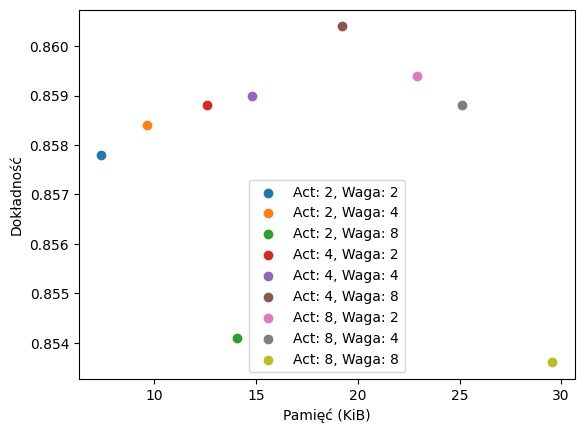

In [23]:
act_bit_widths = [2, 4, 8]
weight_bit_widths = [2, 4, 8]
results = []

input_shape = (1, 28, 28)
output_size = 10

for act_bit_width in act_bit_widths:
    for weight_bit_width in weight_bit_widths:
        print(
            f"Trenowanie modelu z szerokością bitową aktywacji: {act_bit_width}, wag: {weight_bit_width}"
        )
        model, memory, history = create_and_train_model(
            input_shape, output_size, act_bit_width, weight_bit_width, calculate_memory_fn=calculate_memory2
        )
        results.append((act_bit_width, weight_bit_width, memory, history))

fig, ax = plt.subplots()
for result in results:
    ax.scatter(
        result[2],
        result[3]["acc_test"][0],
        label=f"Act: {result[0]}, Weight: {result[1]}",
    )
    ax.text(
        result[2],
        result[3]["acc_test"][0],
        f"({result[0]}, {result[1]}, {result[2]:.2f}KB)",
    )
ax.set_xlabel("Memory (KB)")
ax.set_ylabel("Accuracy")
ax.legend()
plt.show()

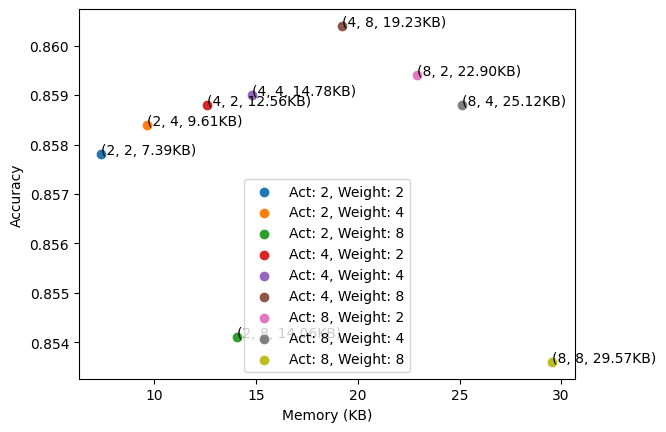

In [29]:
def calculate_memory_usage(
    model,
    activation_bits,
    weight_bits,
    input_size=(1, 28, 28),
):
    x = torch.randn(1, *input_size)
    output_sizes = []
    parameters = 0

    for name, layer in model.named_modules():
        if isinstance(
            layer,
            (
                qnn.QuantIdentity,
                qnn.QuantConv2d,
                qnn.QuantReLU,
                nn.MaxPool2d,
                qnn.QuantLinear,
            ),
        ):
            if isinstance(layer, qnn.QuantLinear):
                x = x.flatten(1)
            x = layer(x)
            output_sizes.append((name, x.size()))

        parameters += sum(np.prod(p.size()) for p in layer.parameters())

    activation_memory = (
        sum(np.prod(size) for name, size in output_sizes if "relu" not in name)
        * activation_bits
    )
    weights_memory = parameters * weight_bits
    total_memory = weights_memory + activation_memory
    return total_memory / 1024

/var/folders/0b/brzkvl1j0tn9xzynh5pr39sw0000gn/T/ipykernel_32607/555700198.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  load_epoch3_file = torch.load("./models/CNN_ep

Trenowanie modelu z szerokością bitową aktywacji: 2, wag: 2
Epoch: 1/3


100%|███████████████████████████████| 938/938 [00:26<00:00, 35.66it/s, accuracy=0.8369, loss=1.6278]


Epoch: 2/3


100%|███████████████████████████████| 938/938 [00:21<00:00, 42.67it/s, accuracy=0.8424, loss=1.6209]


Epoch: 3/3


100%|███████████████████████████████| 938/938 [00:21<00:00, 43.54it/s, accuracy=0.8511, loss=1.6119]


Epoch: 1/1


100%|███████████████████████████████| 157/157 [00:01<00:00, 95.18it/s, accuracy=0.8567, loss=1.6061]


Configuration: Act: 2, Weight: 2, Loss: 1.6060980005264283, Acc: 0.8567, Memory: 152176.0 KB
Trenowanie modelu z szerokością bitową aktywacji: 2, wag: 4
Epoch: 1/3


100%|███████████████████████████████| 938/938 [00:27<00:00, 34.49it/s, accuracy=0.8344, loss=1.6299]


Epoch: 2/3


100%|███████████████████████████████| 938/938 [00:25<00:00, 36.98it/s, accuracy=0.8453, loss=1.6182]


Epoch: 3/3


100%|███████████████████████████████| 938/938 [00:22<00:00, 42.38it/s, accuracy=0.8498, loss=1.6130]


Epoch: 1/1


100%|███████████████████████████████| 157/157 [00:02<00:00, 69.93it/s, accuracy=0.8554, loss=1.6079]


Configuration: Act: 2, Weight: 4, Loss: 1.6078758443832397, Acc: 0.8554, Memory: 177284.0 KB
Trenowanie modelu z szerokością bitową aktywacji: 2, wag: 8
Epoch: 1/3


100%|███████████████████████████████| 938/938 [00:27<00:00, 33.69it/s, accuracy=0.8361, loss=1.6285]


Epoch: 2/3


100%|███████████████████████████████| 938/938 [00:24<00:00, 39.01it/s, accuracy=0.8442, loss=1.6189]


Epoch: 3/3


100%|███████████████████████████████| 938/938 [00:22<00:00, 40.83it/s, accuracy=0.8513, loss=1.6119]


Epoch: 1/1


100%|███████████████████████████████| 157/157 [00:01<00:00, 85.63it/s, accuracy=0.8589, loss=1.6030]


Configuration: Act: 2, Weight: 8, Loss: 1.60301524810791, Acc: 0.8589, Memory: 227500.0 KB
Trenowanie modelu z szerokością bitową aktywacji: 4, wag: 2
Epoch: 1/3


100%|███████████████████████████████| 938/938 [00:24<00:00, 37.71it/s, accuracy=0.8369, loss=1.6279]


Epoch: 2/3


100%|███████████████████████████████| 938/938 [00:23<00:00, 39.86it/s, accuracy=0.8440, loss=1.6194]


Epoch: 3/3


100%|███████████████████████████████| 938/938 [00:23<00:00, 39.13it/s, accuracy=0.8495, loss=1.6137]


Epoch: 1/1


100%|███████████████████████████████| 157/157 [00:01<00:00, 82.56it/s, accuracy=0.8534, loss=1.6089]


Configuration: Act: 4, Weight: 2, Loss: 1.6088518062591552, Acc: 0.8534, Memory: 279244.0 KB
Trenowanie modelu z szerokością bitową aktywacji: 4, wag: 4
Epoch: 1/3


100%|███████████████████████████████| 938/938 [00:26<00:00, 35.54it/s, accuracy=0.8373, loss=1.6274]


Epoch: 2/3


100%|███████████████████████████████| 938/938 [00:22<00:00, 40.92it/s, accuracy=0.8440, loss=1.6190]


Epoch: 3/3


100%|███████████████████████████████| 938/938 [00:23<00:00, 39.84it/s, accuracy=0.8501, loss=1.6129]


Epoch: 1/1


100%|███████████████████████████████| 157/157 [00:01<00:00, 88.55it/s, accuracy=0.8619, loss=1.6012]


Configuration: Act: 4, Weight: 4, Loss: 1.6011531591415404, Acc: 0.8619, Memory: 304352.0 KB
Trenowanie modelu z szerokością bitową aktywacji: 4, wag: 8
Epoch: 1/3


100%|███████████████████████████████| 938/938 [00:24<00:00, 38.25it/s, accuracy=0.8350, loss=1.6290]


Epoch: 2/3


100%|███████████████████████████████| 938/938 [00:23<00:00, 40.23it/s, accuracy=0.8434, loss=1.6199]


Epoch: 3/3


100%|███████████████████████████████| 938/938 [00:23<00:00, 40.58it/s, accuracy=0.8492, loss=1.6139]


Epoch: 1/1


100%|███████████████████████████████| 157/157 [00:01<00:00, 83.87it/s, accuracy=0.8591, loss=1.6036]


Configuration: Act: 4, Weight: 8, Loss: 1.6035916843414306, Acc: 0.8591, Memory: 354568.0 KB
Trenowanie modelu z szerokością bitową aktywacji: 8, wag: 2
Epoch: 1/3


100%|███████████████████████████████| 938/938 [00:24<00:00, 37.90it/s, accuracy=0.8353, loss=1.6292]


Epoch: 2/3


100%|███████████████████████████████| 938/938 [00:22<00:00, 40.85it/s, accuracy=0.8442, loss=1.6193]


Epoch: 3/3


100%|███████████████████████████████| 938/938 [00:23<00:00, 40.14it/s, accuracy=0.8513, loss=1.6123]


Epoch: 1/1


100%|███████████████████████████████| 157/157 [00:01<00:00, 87.37it/s, accuracy=0.8586, loss=1.6038]


Configuration: Act: 8, Weight: 2, Loss: 1.6038158586502076, Acc: 0.8586, Memory: 533380.0 KB
Trenowanie modelu z szerokością bitową aktywacji: 8, wag: 4
Epoch: 1/3


100%|███████████████████████████████| 938/938 [00:25<00:00, 36.98it/s, accuracy=0.8364, loss=1.6287]


Epoch: 2/3


100%|███████████████████████████████| 938/938 [00:22<00:00, 40.82it/s, accuracy=0.8441, loss=1.6190]


Epoch: 3/3


100%|███████████████████████████████| 938/938 [00:22<00:00, 41.28it/s, accuracy=0.8489, loss=1.6137]


Epoch: 1/1


100%|███████████████████████████████| 157/157 [00:01<00:00, 87.70it/s, accuracy=0.8534, loss=1.6075]


Configuration: Act: 8, Weight: 4, Loss: 1.6075257453918457, Acc: 0.8534, Memory: 558488.0 KB
Trenowanie modelu z szerokością bitową aktywacji: 8, wag: 8
Epoch: 1/3


100%|███████████████████████████████| 938/938 [00:25<00:00, 36.99it/s, accuracy=0.8376, loss=1.6273]


Epoch: 2/3


100%|███████████████████████████████| 938/938 [00:22<00:00, 40.93it/s, accuracy=0.8456, loss=1.6184]


Epoch: 3/3


100%|███████████████████████████████| 938/938 [00:23<00:00, 40.30it/s, accuracy=0.8505, loss=1.6120]


Epoch: 1/1


100%|███████████████████████████████| 157/157 [00:01<00:00, 82.36it/s, accuracy=0.8528, loss=1.6089]


Configuration: Act: 8, Weight: 8, Loss: 1.6088670820236206, Acc: 0.8528, Memory: 608704.0 KB


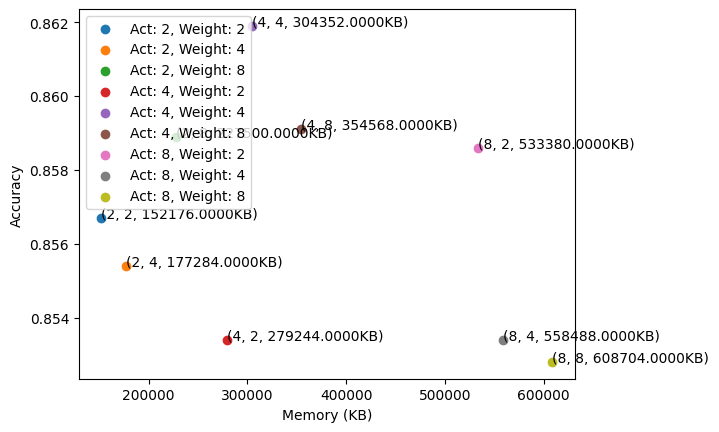

In [30]:
act_bit_widths = [2, 4, 8]
weight_bit_widths = [2, 4, 8]
results = []

input_shape = (1, 28, 28)
output_size = 10

for act_bit_width in act_bit_widths:
    for weight_bit_width in weight_bit_widths:
        print(
            f"Trenowanie modelu z szerokością bitową aktywacji: {act_bit_width}, wag: {weight_bit_width}"
        )
        model, memory, history = create_and_train_model(
            input_shape, output_size, act_bit_width, weight_bit_width, calculate_memory_fn=calculate_memory_usage
        )
        results.append((act_bit_width, weight_bit_width, memory, history))

fig, ax = plt.subplots()
for result in results:
    ax.scatter(
        result[2],
        result[3]["acc_test"][0],
        label=f"Act: {result[0]}, Weight: {result[1]}",
    )
    ax.text(
        result[2],
        result[3]["acc_test"][0],
        f"({result[0]}, {result[1]}, {result[2]:.4f}KB)",
    )
ax.set_xlabel("Memory (KB)")
ax.set_ylabel("Accuracy")
ax.legend()
plt.show()